# Local Feature Importance and Reason Codes using LOCO
***

Based on: Lei, Jing, G’Sell, Max, Rinaldo, Alessandro, Tibshirani, Ryan J., and Wasserman, Larry. Distribution-free predictive inference for regression. *Journal of the American Statistical Association*, 2017.

http://www.stat.cmu.edu/~ryantibs/papers/conformal.pdf

## Preliminaries: imports, start h2o, load and clean data 

In [1]:
# imports
import h2o 
import numpy as np
import pandas as pd
from h2o.estimators.gbm import H2OGradientBoostingEstimator

In [2]:
# start h2o
h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_112"; Java(TM) SE Runtime Environment (build 1.8.0_112-b16); Java HotSpot(TM) 64-Bit Server VM (build 25.112-b16, mixed mode)
  Starting server from /Users/phall/anaconda/lib/python3.5/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmpukn9e0q_
  JVM stdout: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmpukn9e0q_/h2o_phall_started_from_python.out
  JVM stderr: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmpukn9e0q_/h2o_phall_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,05 secs
H2O cluster version:,3.12.0.1
H2O cluster version age:,19 days
H2O cluster name:,H2O_from_python_phall_kluwzb
H2O cluster total nodes:,1
H2O cluster free memory:,3.556 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"
H2O connection url:,http://127.0.0.1:54321
H2O connection proxy:,None


#### Load and prepare data for modeling

In [3]:
# load clean data
path = '../../03_regression/data/train.csv'
frame = h2o.import_file(path=path)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [4]:
# assign target and inputs
y = 'SalePrice'
X = [name for name in frame.columns if name not in [y, 'Id']]

#### LOCO is simpler to use with data containing no missing values

In [5]:
# determine column types
# impute
reals, enums = [], []
for key, val in frame.types.items():
    if key in X:
        if val == 'enum':
            enums.append(key)
        else: 
            reals.append(key)
            
_ = frame[reals].impute(method='median')
_ = frame[enums].impute(method='mode')

In [6]:
# split into training and validation
train, valid = frame.split_frame([0.7])

#### LOCO is unfit for use with data in which strong correlations exist between input variables

In [7]:
# print out correlated pairs
corr = train[reals].cor()
for i in range(0, corr.shape[0]):
    for j in range(0, corr.shape[1]):
        if i != j:
            if np.abs(corr[i, j]) > 0.7:
                print(corr.columns[i], corr.columns[j])

TotalBsmtSF 1stFlrSF
GrLivArea TotRmsAbvGrd
1stFlrSF TotalBsmtSF
GarageCars GarageArea
GarageYrBlt YearBuilt
YearBuilt GarageYrBlt
TotRmsAbvGrd GrLivArea
GarageArea GarageCars


#### Remove one var from each correlated pair

In [8]:
X_reals_decorr = [i for i in reals if i not in  ['GarageYrBlt', 'TotRmsAbvGrd', 'TotalBsmtSF', 'GarageCars']]

## Train a predictive model

In [9]:
# train GBM model
model = H2OGradientBoostingEstimator(ntrees=100,
                                     max_depth=10,
                                     distribution='huber',
                                     learn_rate=0.1,
                                     stopping_rounds=5,
                                     seed=12345)

model.train(y=y, x=X_reals_decorr, training_frame=train, validation_frame=valid)

preds = valid['Id'].cbind(model.predict(valid))

gbm Model Build progress: |███████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


## Retrain predictive model
* Each time leaving one input (covariate) out 
* To generate local feature importance values for each decision

In [12]:
h2o.no_progress()

for k, i in enumerate(X_reals_decorr):

    # train and predict without Xi
    X_loco = [j for j in X_reals_decorr if j != i]
    model.train(y=y, x=X_loco, training_frame=train, validation_frame=valid)
    preds_loco = model.predict(valid)
    
    # create a new, named column for the LOCO prediction
    preds_loco.columns = [i]
    preds = preds.cbind(preds_loco)
    
    # subtract the LOCO prediction from 
    preds[i] = preds[i] - preds['predict']
    
    print('LOCO Progress: ' + i + ' (' + str(k+1) + '/' + str(len(X_reals_decorr)) + ') ...')
    
print('Done.')  

preds.head()

LOCO Progress: PoolArea (1/32) ...
LOCO Progress: LowQualFinSF (2/32) ...
LOCO Progress: GrLivArea (3/32) ...
LOCO Progress: 1stFlrSF (4/32) ...
LOCO Progress: YrSold (5/32) ...
LOCO Progress: OverallQual (6/32) ...
LOCO Progress: HalfBath (7/32) ...
LOCO Progress: BsmtUnfSF (8/32) ...
LOCO Progress: BsmtHalfBath (9/32) ...
LOCO Progress: BsmtFullBath (10/32) ...
LOCO Progress: MoSold (11/32) ...
LOCO Progress: OpenPorchSF (12/32) ...
LOCO Progress: OverallCond (13/32) ...
LOCO Progress: BsmtFinSF2 (14/32) ...
LOCO Progress: MasVnrArea (15/32) ...
LOCO Progress: MiscVal (16/32) ...
LOCO Progress: 3SsnPorch (17/32) ...
LOCO Progress: YearBuilt (18/32) ...
LOCO Progress: EnclosedPorch (19/32) ...
LOCO Progress: FullBath (20/32) ...
LOCO Progress: LotFrontage (21/32) ...
LOCO Progress: 2ndFlrSF (22/32) ...
LOCO Progress: GarageArea (23/32) ...
LOCO Progress: ScreenPorch (24/32) ...
LOCO Progress: LotArea (25/32) ...
LOCO Progress: YearRemodAdd (26/32) ...
LOCO Progress: Fireplaces (27/32)

Id,predict,PoolArea,PoolArea0,LowQualFinSF,GrLivArea,1stFlrSF,YrSold,OverallQual,HalfBath,BsmtUnfSF,BsmtHalfBath,BsmtFullBath,MoSold,OpenPorchSF,OverallCond,BsmtFinSF2,MasVnrArea,MiscVal,3SsnPorch,YearBuilt,EnclosedPorch,FullBath,LotFrontage,2ndFlrSF,GarageArea,ScreenPorch,LotArea,YearRemodAdd,Fireplaces,BsmtFinSF1,KitchenAbvGr,MSSubClass,WoodDeckSF,BedroomAbvGr
2,178580,-178580,178580,-1086.62,-6335.85,3321.83,1964.41,9054.63,-3599.37,-2078.66,-1920.79,-4468.47,-1608.86,1886.11,-9420.62,-1069.51,-68.3989,-621.834,-1624,-8066.81,-312.497,-4330.58,2608.37,1165.16,8699.31,-4199.97,-736.469,7414.09,-4919.65,-6805.14,-323.205,76.1609,1807.25,-2636.2
5,305995,-305995,305995,2675.17,12605.6,14665.1,-1414.5,-36563.6,8034.32,8065.8,-3766.2,-4924.33,13809,-3013.2,8366.06,5854.68,1254.21,-850.855,1373.68,3768.94,11788.2,10254,328.111,-6539.47,-1916.86,-899.864,-6887.44,-964.715,-5542.37,-2453.07,11986.5,-3982.97,-14628.5,-6681.1
6,163661,-163661,163661,1039.44,-20206.3,5202.88,-2432.7,8738.74,-4499.89,-1021.26,773.246,-4282.67,-5554.16,-365.635,-12724.1,-6621.39,-1765.19,441.467,390.515,-11770.3,-3510.99,3616.45,-1158.77,-6291.25,-469.19,-1938.77,-7911.67,997.456,-1665.01,-21033.4,-5121.93,-4519.94,-1713.28,-2585.39
7,284257,-284257,284257,-1479.14,-5026.65,1510.86,11202.8,-7550.07,7324.25,2082.37,-858.55,7597.47,3476.66,17585,9372.8,4037.71,6542.64,-295.984,-2743,9443.3,2233.37,2917.46,-1257.21,972.025,27357,4011.12,19082.1,10625.9,4740.29,5629.64,9549.68,4757.03,4790.73,6740.31
9,162558,-162558,162558,-219.427,-11090,8966.68,-853.746,-17083,2738.67,10968.5,2127.91,6598.16,560.206,5905.31,2850.39,4928.81,5457.91,-418.581,634.967,7520.54,2664.11,-2258.69,5201.36,-4115.35,-919.55,2210.45,14280.8,4059.94,-1768.61,5295.25,1565.55,-3849.83,2099.67,-1305.24
14,212928,-212928,212928,-244.034,11303.5,-5502.85,6154.15,24728.4,7400.92,4205.05,-1084.39,-5683.23,8813.59,10331,6413.31,4231.08,-365.796,542.678,1030.21,6018.24,2111.86,9725.34,-1617.47,7007.04,1563.15,-446.621,9225.61,995.996,9728.03,10390.3,-1566.43,5868.1,-1078.08,2773.95
18,117756,-117756,117756,459.269,-4316.51,1653.22,123.549,-2362.46,1072.43,5529.47,1870.63,1084.77,2459.21,4083.52,1545.63,3034.56,2273.94,-175.682,-106.946,-9923.3,2155.75,760.575,6679.92,-3924.33,1976.42,4463.69,-4500.46,1766.74,6808.69,6276.32,2301.77,248.963,-312.735,2493.45
23,244641,-244641,244641,1068.25,3091.01,-6501.97,-1877.3,-28099.6,431.703,9678.98,3228.01,13627.5,13310.5,5612.05,5124.58,8826.07,-6393.07,-119.509,626.148,-1935.96,5424.95,1738.86,3237.48,-628.245,-18197.7,1765.47,-1471.95,5307.12,6134.09,8689.76,15028.6,5984.06,-304.474,1075.33
25,143206,-143206,143206,-279.743,5728.1,-1897.57,-430.964,371.087,-3600.03,-429.021,-499.686,-2798.54,-868.141,1802.58,4630.98,-742.357,197.822,-965.447,-642.065,-7080.87,-2447.6,-1125.33,-3496.86,573.547,4719.25,-1107.97,2816.83,-3575.83,1102.64,4479.63,2572.76,-5943.32,-2567.77,3909.32
28,308369,-308369,308369,287.235,-18425.9,-1406.49,2296.81,-2671.89,-8655.65,-7469.92,-251.874,6656.56,-3155.83,11541.6,876.054,4007.81,7016.77,126.482,-103.458,8932.41,6172.85,-671.202,1734.41,13565.4,-8270.9,-903.821,-4013.83,1609.37,-1686.56,-17906.3,-6806.61,2017.35,3103.37,5019.18


The numeric values in each column are an estimate of how much each variable contributed to each decision. These values can tell you how a variable and it's values were weighted in any given decision by the model. These values are crucially important for machine learning interpretability and are often to referred to "local feature importance", "reason codes", or "turn-down codes." The latter phrases are borrowed from credit scoring. Credit lenders must provide reasons for turning down a credit application, even for automated decisions. Reason codes can be easily extracted from LOCO local feature importance values, by simply ranking the variables that played the largest role in any given decision.

#### Helper function for finding quantile indices

In [13]:
def get_quantile_dict(y, id_, frame):

    """ Returns the percentiles of a column y as the indices for another column id_.
    
    Args:
        y: Column in which to find percentiles.
        id_: Id column that stores indices for percentiles of y.
        frame: H2OFrame containing y and id_. 
    
    Returns:
        Dictionary of percentile values and index column values.
    
    """
    
    quantiles_df = frame.as_data_frame()
    quantiles_df.sort_values(y, inplace=True)
    quantiles_df.reset_index(inplace=True)
    
    percentiles_dict = {}
    percentiles_dict[0] = quantiles_df.loc[0, id_]
    percentiles_dict[99] = quantiles_df.loc[quantiles_df.shape[0]-1, id_]
    inc = quantiles_df.shape[0]//10
    
    for i in range(1, 10):
        percentiles_dict[i * 10] = quantiles_df.loc[i * inc,  id_]

    return percentiles_dict

get_quantile_dict('predict', 'Id', preds)

{0: 969.0,
 10: 1444.0,
 20: 224.0,
 30: 1130.0,
 40: 355.0,
 50: 1364.0,
 60: 212.0,
 70: 1231.0,
 80: 392.0,
 90: 1373.0,
 99: 524.0}

#### Plot some reason codes for a representative row

In [14]:
%matplotlib inline

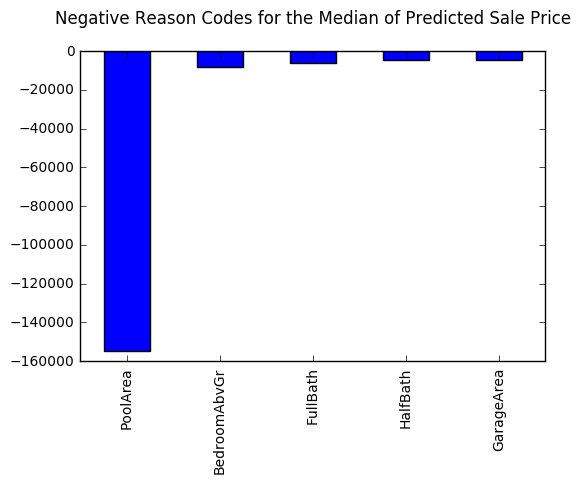

In [15]:
median_loco = preds[preds['Id'] == 644, :].as_data_frame().drop(['Id', 'predict'], axis=1)
median_loco = median_loco.T.sort_values(by=0)[:5]
_ = median_loco.plot(kind='bar', 
                     title='Negative Reason Codes for the Median of Predicted Sale Price\n', 
                     legend=False)

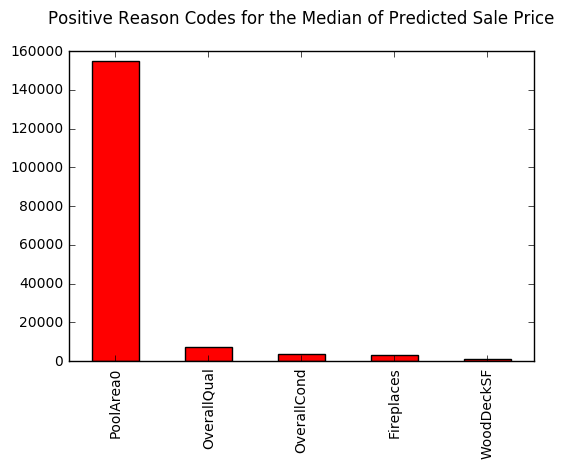

In [16]:
median_loco = preds[preds['Id'] == 644, :].as_data_frame().drop(['Id', 'predict'], axis=1)
median_loco = median_loco.T.sort_values(by=0, ascending=False)[:5]
_ = median_loco.plot(kind='bar', 
                     title='Positive Reason Codes for the Median of Predicted Sale Price\n', 
                     color='r',
                     legend=False)

#### Shutdown H2O

In [17]:
h2o.cluster().shutdown(prompt=True)

Are you sure you want to shutdown the H2O instance running at http://127.0.0.1:54321 (Y/N)? y
H2O session _sid_989d closed.
